In [2]:
%load_ext autoreload
%autoreload 2

In [125]:
import numpy as np
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.transform import rescale

from sladsnet.input_params import ERDInputParams, GeneralInputParams, SampleParams
from sladsnet.code.measurement_interface import TransmissionSimulationMeasurementInterface, ExperimentMeasurementInterface
from sladsnet.code.erd import SladsSklearnModel
from sladsnet.code.results import Result
from sladsnet.code.base import ExperimentalSample
from sladsnet.code.sampling import run_sampling
from sladsnet.code.utils import renormalize

In [41]:
from skimage.metrics import structural_similarity, mean_squared_error

from readMDA import readMDA

In [5]:
cm = mpl.cm.viridis.copy()
#cm.set_bad('black')
cnorm = mpl.colors.LogNorm

In [6]:
def clean_and_normalize(x):
    x = np.nan_to_num(x, nan=0, posinf=0, neginf=0)
    x = (x - x.min()) / (x.max() - x.min())
    return x
    

In [7]:
C_VALUE = 2
train_base_path = Path.cwd().parent.parent / 'ResultsAndData/TrainingData/cameraman/'
erd_model = SladsSklearnModel(load_path=train_base_path / f'c_{C_VALUE}/erd_model_relu.pkl')

In [8]:
exp_data = np.load('coarsescan1.npy')

In [9]:
xrf = np.swapaxes(np.swapaxes(exp_data[4,::-1,::-1].reshape(6,4,100,100),1,2),1,3).reshape(600,400)[:,::-1]
int1 = np.swapaxes(np.swapaxes(exp_data[5,::-1,::-1].reshape(6,4,100,100),1,2),1,3).reshape(600,400)[:,::-1]

In [10]:
xrf_rescaled = np.random.poisson(rescale(xrf, 0.5))
int_rescaled = np.random.poisson(rescale(int1, 0.5))
normalized_int = renormalize(int_rescaled)

In [11]:
xrf_threshold = xrf_rescaled < 10

In [12]:
int_rescaled.shape, int1.shape

((300, 200), (600, 400))

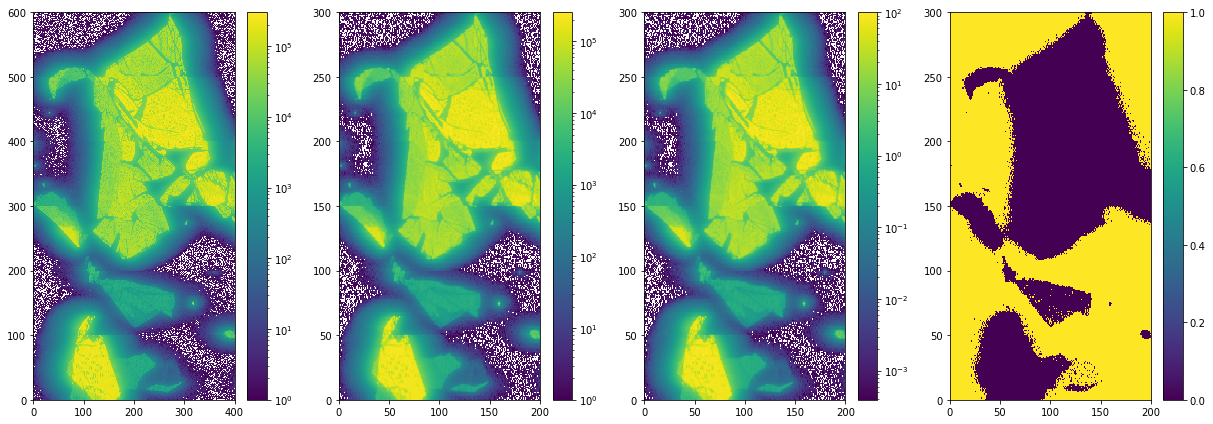

In [13]:
fig, axs = plt.subplots(1, 4, figsize=[17,6])
plt.subplot(1,4,1)
plt.pcolormesh(int1, cmap=cm, norm=cnorm())
plt.colorbar()
plt.subplot(1,4,2)
plt.pcolormesh(int_rescaled, cmap=cm, norm=cnorm())
plt.colorbar()
plt.subplot(1,4,3)
plt.pcolormesh(normalized_int, cmap=cm, norm=cnorm())
plt.colorbar()
plt.subplot(1,4,4)
plt.pcolormesh(xrf_threshold, cmap=cm)#, norm=cnorm())
plt.colorbar()
plt.tight_layout()

In [28]:
inner_batch_size = 100
initial_scan_points_num = 500

stop_ratio = 0.3
store_results_percentage = 1

affected_neighbors_window_min = 5
affected_neighbors_window_max = 15
full_erd_recalculation_frequency = 1

In [62]:
params_erd = ERDInputParams(c_value=C_VALUE,
                            full_erd_recalculation_frequency=full_erd_recalculation_frequency,
                            affected_neighbors_window_min=affected_neighbors_window_min,
                            affected_neighbors_window_max=affected_neighbors_window_max)
params_gen = GeneralInputParams()

sample_params = SampleParams(image_shape=(300, 200),
                             inner_batch_size=inner_batch_size,
                             initial_scan_points_num=initial_scan_points_num,
                             initial_scan_ratio=None,
                             stop_ratio=stop_ratio,
                             random_seed=11)


measurement_interface = ExperimentMeasurementInterface()#'instructions.csv', num_initial_idxs= 2000)
#interface.perform_measurement(sample_params.initial_idxs)
#measurement_interface = TransmissionSimulationMeasurementInterface(image=normalized_int)

In [30]:
np.savetxt('instructions_000.csv', sample_params.initial_idxs, delimiter=',', fmt='%10d')

In [126]:
sample = ExperimentalSample(sample_params=sample_params,
                general_params=params_gen,
                erd_params=params_erd,
                measurement_interface=measurement_interface,
                erd_model=erd_model)
results = Result()

In [127]:
mda = readMDA("26idbSOFT_0207", verbose=False)

In [128]:
x = (np.round((np.array(mda[1].d[32].data)-1102)/3.,0) +100).astype(np.int16)
y = (np.round((np.array(mda[1].d[31].data)+3332)/3.,0) +150).astype(np.int16)
data_intensities = np.array(mda[1].d[3].data)

In [129]:
route = np.array((y, x)).T

In [130]:
sample.measurement_interface.finalize_external_measurement(data_intensities)
sample.perform_measurements(route)

In [131]:
sample.reconstruct_and_compute_erd()  

In [132]:
total_erd = sample.ERD.sum()

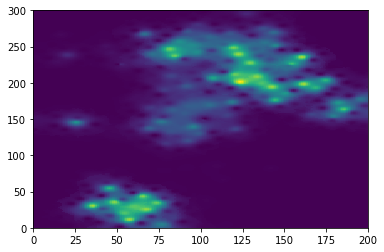

In [133]:
plt.pcolormesh(sample.recon_image)

In [134]:
erds_all = []
recons_all = []
xpoints_all = []
ypoints_all = []
for i in range(209,243):
    mda = readMDA("26idbSOFT_{0:04d}.mda".format(i), verbose=False)
    x = (np.round((np.array(mda[1].d[32].data)-1102)/3.,0) +100).astype(np.int16)
    y = (np.round((np.array(mda[1].d[31].data)+3332)/3.,0) +150).astype(np.int16)
    data = np.array(mda[1].d[3].data)
    
    xpoints = x[:-1]
    ypoints = y[:-1]
    route_idxs = np.array((ypoints, xpoints), dtype='int').T
    #route_shape = np.shape(route_idxs)[0]

    new_intensities = data[1:]
    
    sample.measurement_interface.finalize_external_measurement(new_intensities)
    sample.perform_measurements(route_idxs)
    sample.reconstruct_and_compute_erd()  
    erd_this = sample.ERD.sum()
    erds_all.append(erd_this)
    recons_all.append(sample.recon_image.copy())
    print(erd_this)

6652847.30761016
5948652.469395253
5520265.067315401
5318571.6003781315
4938754.579243296
4788825.807558804
4424443.680876956
4233600.892422906
4127951.8829043047
4057639.8239422627
4006056.921095222
3966126.620733419
3941370.8924336536
3899438.4944354617
3848321.267913969
3821265.467431878
3774149.996200736
3745233.6629914744
3740832.548687177
3726083.873713251
3655356.6558142663
3655358.075132958
3597291.1112841107
3574358.610962016
3561236.724874321
3547017.4737412883
3521371.091868222
3500218.4569837195
3496061.1731860973
3598151.673983405
3665337.755720735
3553520.0100215706
3497595.0850533606
3566149.8012926886


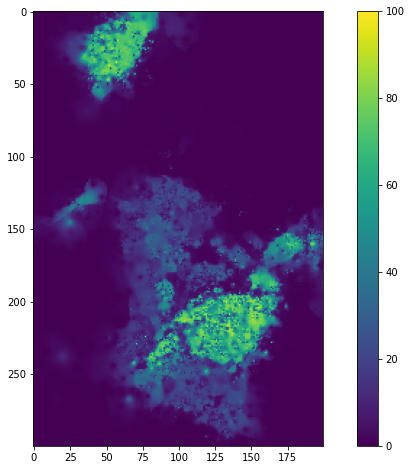

In [135]:
plt.figure(figsize=[12, 8])
plt.imshow(recons_all[-1])
plt.colorbar()

In [136]:
sample.mask.sum() / sample_params.image_size

0.0878

In [ ]:
run_sampling(sample, results=results, results_frequency_step=0, results_frequency_percentage=1, 
             disable_progress_bar=False, debug=False, indices_to_actually_measure=50)

In [35]:
results.size

13

In [36]:
results.outputs.masks[8].sum() / sample_params.image_size

0.08083333333333333

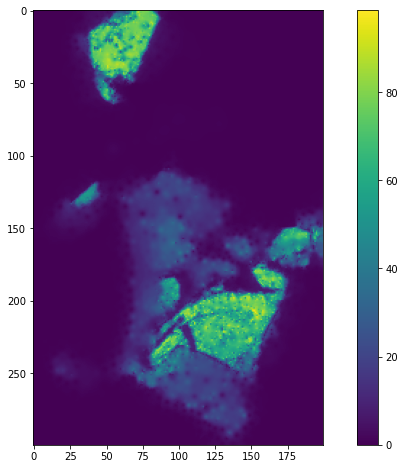

In [39]:
plt.figure(figsize=[12, 8])
plt.imshow(results.outputs.recons[8])
plt.colorbar()

In [31]:
erds = results.outputs.erds
total_erds = np.sum(erds, axis=(1,2))

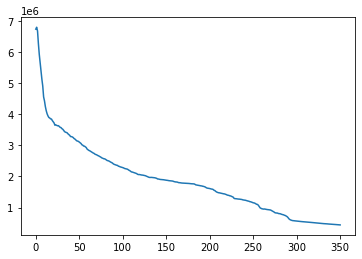

In [32]:
plt.plot(total_erds)

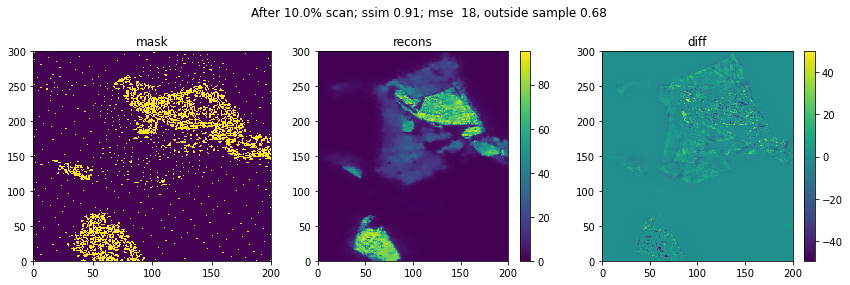

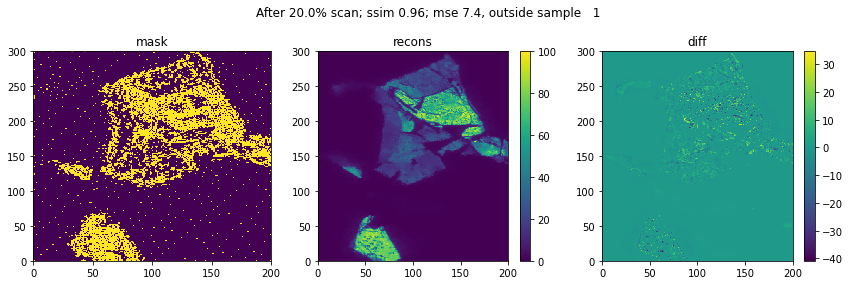

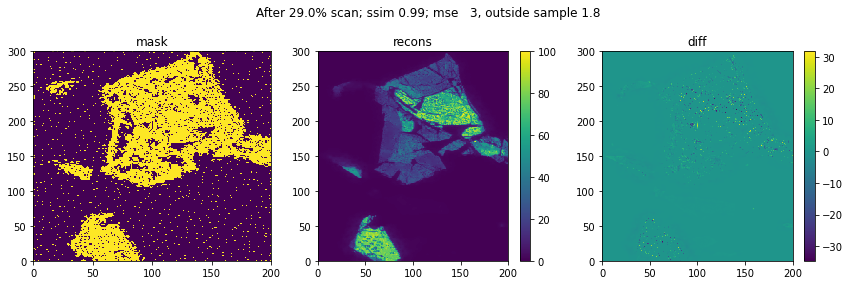

In [54]:
for i in range(3):
    scan_ratio = (i + 1) * 0.1
    percent = int(scan_ratio * 100)
    
    if percent >= results.size:
        percent = results.size - 1
    
    actual_percent = round(results.outputs.masks[percent].sum() / results.outputs.masks[percent].size * 100, 0)
    percent_outside_sample = results.outputs.masks[percent][xrf_threshold].sum() / results.outputs.masks[percent].size * 100
    
    
    fig, axs = plt.subplots(1, 3, figsize=[12, 4])
    plt.subplot(1, 3, 1)
    plt.pcolormesh(results.outputs.masks[percent])
    plt.title('mask')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(results.outputs.recons[percent])
    plt.colorbar()
    plt.title('recons')
    plt.subplot(1, 3, 3)
    err = measurement_interface.image - results.outputs.recons[percent]
    plt.pcolormesh(measurement_interface.image - results.outputs.recons[percent])
    plt.colorbar()
    plt.title('diff')
    
    ssim = structural_similarity(results.outputs.recons[percent], measurement_interface.image, 
                                 data_range=255)
    mse = mean_squared_error(results.outputs.recons[percent], measurement_interface.image)
    
    plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, outside sample {percent_outside_sample:3.2g}')
    plt.tight_layout()
    plt.show()
